In [76]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import re
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer
from yellowbrick.features import Rank1D
from sklearn.linear_model import LinearRegression
from yellowbrick.model_selection import FeatureImportances
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.target import FeatureCorrelation
import matplotlib.pyplot as plt
import functools
import nltk
import wordcloud
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMRegressor
from category_encoders.target_encoder import TargetEncoder
import warnings
warnings.filterwarnings('ignore')

In [7]:
%%time 
df = pd.read_excel('~/Documents/DSO545/Project/Datasets/Property Data Compiled.xlsx')

CPU times: user 32.9 s, sys: 168 ms, total: 33.1 s
Wall time: 33.1 s


In [8]:
df.head()

,Row,PropID,Property Address,Property Name,Star Rating,Energy Star,LEED Certified,Building Status,Secondary Type,Market Name,Submarket Name,City,State,Zip,County Name,For Sale Price,For Sale Status,Land Area (AC),Number Of Stories,Style,Number Of Units,$Price/Unit,Cap Rate,Vacancy %,Avg Unit SF,Avg Asking/Unit,Avg Asking/SF,Avg Effective/Unit,Avg Effective/SF,Avg Concessions %,% Studios,% 1-Bed,% 2-Bed,% 3-Bed,% 4-Bed,Rent Type,Affordable Type,Market Segment,Parking Spaces/Unit,Number Of Parking Spaces,Days On Market,Amenities,Number Of 1 Bedrooms,Number Of 2 Bedrooms,Number Of 3 Bedrooms,Number Of 4 Bedrooms,Architect Name,Building Class,Building Park,Closest Transit Stop,Closest Transit Stop Dist (mi),Closest Transit Stop Walk Time (min),Construction Material,Developer Name,Features,Four Bedroom Asking Rent/SF,Four Bedroom Asking Rent/Unit,Four Bedroom Avg SF,Four Bedroom Concessions %,Four Bedroom Effective Rent/SF,Four Bedroom Effective Rent/Unit,Four Bedroom Vacancy %,Four Bedroom Vacant Units,Number Of Studios,One Bedroom Asking Rent/SF,One Bedroom Asking Rent/Unit,One Bedroom Avg SF,One Bedroom Concessions %,One Bedroom Effective Rent/SF,One Bedroom Effective Rent/Unit,One Bedroom Vacancy %,One Bedroom Vacant Units,Owner Contact,Owner Name,Percent Leased,Property Manager Address,Property Manager City State Zip,Property Manager Contact,Property Manager Name,Property Manager Phone,PropertyID,PropertyType,Serial,Studio Asking Rent/SF,Studio Asking Rent/Unit,Studio Avg SF,Studio Concessions %,Studio Effective Rent/SF,Studio Effective Rent/Unit,Studio Vacancy %,Studio Vacant Units,Submarket Cluster,Three Bedroom Asking Rent/SF,Three Bedroom Asking Rent/Unit,Three Bedroom Avg SF,Three Bedroom Concessions %,Three Bedroom Effective Rent/SF,Three Bedroom Effective Rent/Unit,Three Bedroom Vacancy %,Three Bedroom Vacant Units,Total Buildings,Two Bedroom Asking Rent/SF,Two Bedroom Asking Rent/Unit,Two Bedroom Avg SF,Two Bedroom Concessions %,Two Bedroom Effective Rent/SF,Two Bedroom Effective Rent/Unit,Two Bedroom Vacancy %,Two Bedroom Vacant Units,Year Built,Year Renovated,Zoning,Owner Address,Owner City State Zip,RBA,Parcel Number 1(Min),Parcel Number 2(Max),Last Sale Date,Last Sale Price,Latitude,Longitude,Acq Notes (my data),2010 Avg Age(1m),2010 Med Age(1m),2010 Pop Age 0-4(1m),2010 Pop Age 10-14(1m),2010 Pop Age 15-19(1m),2010 Pop Age 20-24(1m),2010 Pop Age 45-49(1m),2010 Pop Age 50-54(1m),2010 Pop Age 55-59(1m),2010 Pop Age 5-9(1m),2010 Pop Age 60-64(1m),2010 Pop Age 65+(1m),2010 Pop Age 85+(1m),2019 Avg Age(1m),2019 Avg Age&#044; Female(1m),2019 Avg Age&#044; Male(1m),2019 HH Age 15-24(1m),2019 HH Age 25-34(1m),2019 HH Age 35-44(1m),2019 HH Age 45-54(1m),2019 HH Age 55-64(1m),2019 HH Age 65-74(1m),2019 HH Age 75-84(1m),2019 HH Age 85+(1m),2019 Med Age(1m),2019 Med Age&#044; Female(1m),2019 Med Age&#044; Male(1m),2019 Median HH Age(1m),2019 Pop Age <19(1m),2019 Pop Age 0-4(1m),2019 Pop Age 10-14(1m),2019 Pop Age 15-19(1m),2019 Pop Age 20-24(1m),2019 Pop Age 20-64(1m),2019 Pop Age 25-29(1m),2019 Pop Age 30-34(1m),2019 Pop Age 35-39(1m),2019 Pop Age 40-44(1m),2019 Pop Age 45-49(1m),2019 Pop Age 50-54(1m),2019 Pop Age 55-59(1m),2019 Pop Age 5-9(1m),2019 Pop Age 60-64(1m),2019 Pop Age 65+(1m),2019 Pop Age 65-69(1m),2019 Pop Age 70-74(1m),2019 Pop Age 75-79(1m),2019 Pop Age 80-84(1m),2019 Pop Age 85+(1m),2024 Avg Age(1m),2024 Avg Female Age(1m),2024 Avg Male Age(1m),2024 HH Age 15-24(1m),2024 HH Age 25-34(1m),2024 HH Age 35-44(1m),2024 HH Age 45-54(1m),2024 HH Age 55-64(1m),2024 HH Age 65-74(1m),2024 HH Age 75-84(1m),2024 HH Age 85+(1m),2024 Med Age(1m),2024 Median HH Age(1m),2024 Pop Age <19(1m),2024 Pop Age 0-4(1m),2024 Pop Age 10-14(1m),2024 Pop Age 15-19(1m),2024 Pop Age 20-24(1m),2024 Pop Age 20-64(1m),2024 Pop Age 25-29(1m),2024 Pop Age 30-34(1m),2024 Pop Age 35-39(1m),2024 Pop Age 40-44(1m),2024 Pop Age 45-49(1m),2024 Pop Age 50-54(1m),2024 Pop Age 55-59(1m),2024 Pop Age 5-9(1m),2024 Pop Age 60-64(1m),2024 Pop Age 65+(1m),

# Data Cleaning

### Replace NAs in number of bedrooms with zeros

In [9]:
for key in df.keys():
    if 'bed' in key.lower():
        df[key].fillna(0, inplace = True)
    elif 'studio' in key.lower():
        df[key].fillna(0, inplace = True)

### Clean state names 

In [10]:
df['State'] = df['State'].apply(lambda x: re.sub('[^a-z]', '', x.lower()).upper())

### Consider only Existing properties and ones Under Renovation

In [11]:
search_mask = df['Building Status'].apply(lambda x: True if x in ['Existing','Under Renovation'] else False)
df = df[search_mask]

### Clean Year Renovated

In [12]:
df['Year Renovated'].fillna(-1, inplace = True)

### Clean Building Material

#### Remove NaNs in Building Materials by replacing with the most frequently Material used in the County

In [13]:
county_mat = df.groupby('County Name')['Construction Material'].describe()['top']
county = df['County Name'].tolist()
materials = df['Construction Material'].tolist()

for i in range(len(materials)):
    if type(materials[i]) == float:
        materials[i] = county_mat[county[i]]
        
df['Construction Material'] = materials

#### Remove remaining NaNs with most frequently used Material across the Dataset

In [14]:
mat = df['Construction Material'].value_counts().idxmax()
df['Construction Material'].fillna(mat, inplace = True)

### Remove NaNs from Average Effective Rent 

In [15]:
df = df[~df['Avg Effective/SF'].isna()]

### Make all Zip code 5 digits

In [16]:
zip_res = df['Zip'].apply(lambda x: len(str(x))).min()
df['Zip'] = df['Zip'].apply(lambda x: int(str(x)[:zip_res]))

### Clean Features 

#### Split Features in individual columns

In [17]:
%%time
df['Features'].fillna('None', inplace = True)
feature_list = df['Features'].apply(lambda x: np.array(list(map(lambda y: y[1:] if y[0] == ' ' else y, x.split(','))))).values
features = []
for row in feature_list:
    for feature in row:
        features.append(feature)

features = list(set(features))

for item in features:
    df[item] = df['Features'].apply(lambda x: 1 if item in x else 0)

CPU times: user 758 ms, sys: 13.7 ms, total: 771 ms
Wall time: 768 ms


#### Remove features present in less than 5% of the rows

In [18]:
%%time

feature_freq = pd.DataFrame({
    'Feature': features,
    'Percentage': list(map(lambda x: sum(df[x])/df.shape[0], features))
})
feature_freq.sort_values('Percentage', ascending = False, inplace = True)

for feature in features:
    if feature not in feature_freq[feature_freq['Percentage'] > 0.05]['Feature'].values:
        df.drop(columns=[feature], inplace = True)


CPU times: user 1.19 s, sys: 154 ms, total: 1.34 s
Wall time: 1.34 s


### Zero Imputation

In [19]:
#Number Of Parking Spaces, Parking Spaces/Unit

In [20]:
for key in ['Number Of Parking Spaces', 'Parking Spaces/Unit']:
    df[key].fillna(0, inplace = True)

In [21]:
#Number Of Parking Spaces, Parking Spaces/Unit

### Mode Imputation

In [22]:
mode = df['Total Buildings'].mode()[0]
df['Total Buildings'].fillna(mode, inplace = True)

In [23]:
#Total Buildings, 

### Impute by mode in Zip Code

In [24]:
%%time 
zip_code = df['Zip'].tolist()
for item in ['Market Segment', 'Number Of Stories', 'Vacancy %', 'Closest Transit Stop Dist (mi)', 'Submarket Cluster', 'Submarket Name', 'Closest Transit Stop']:
    item_list = df[item].tolist()
    if df[item].dtype == 'object':
        mode_zip = df.groupby('Zip')[item].describe()['top']
    else:
        mode_zip = df.groupby('Zip')[item].median()
    for i in range(len(item_list)):
        if type(item_list[i]) == float:
            if np.isnan(item_list[i]):
                item_list[i] = mode_zip[zip_code[i]]
    df[item] = item_list

CPU times: user 11.1 s, sys: 122 ms, total: 11.2 s
Wall time: 11.2 s


### Create a data frame with percentage of NAs for every column

In [25]:
def na_freq(df):
    df_na = (df.isna().sum()/df.shape[0]).reset_index().sort_values(0, ascending = False)
    df_na.rename(columns = {'index':'key', 0:'values'}, inplace = True)
    return df_na

In [26]:
df_na = na_freq(df)
df_na

,key,values
81,Serial,1.000000
120,Acq Notes (my data),1.000000
73,Percent Leased,1.000000
21,Cap Rate,0.999759
20,$Price/Unit,0.999097
14,For Sale Price,0.999097
5,Energy Star,0.997230
39,Days On Market,0.994882
47,Building Park,0.976697
45,Architect Name,0.954236


In [27]:
for key in df_na[df_na['values']>0.1]['key'].tolist():
    df.drop(columns=[key], inplace = True)

In [28]:
df_na = na_freq(df)
df_na

,key,values
13,For Sale Status,0.083037
76,Submarket Cluster,0.059011
8,Submarket Name,0.059011
41,Closest Transit Stop Dist (mi),0.056964
40,Closest Transit Stop,0.056964
14,Land Area (AC),0.054555
34,Amenities,0.047631
186,Situs_Num,0.023063
97,Owner City State Zip,0.012344
96,Owner Address,0.010959


Year Built, Construction Material, Features, Star Rating, Owner Name, Owner Address, Number Of Stories, Land Area (AC),


In [29]:
df.head()

,Row,PropID,Property Address,Property Name,Star Rating,Building Status,Secondary Type,Market Name,Submarket Name,City,State,Zip,County Name,For Sale Status,Land Area (AC),Number Of Stories,Style,Number Of Units,Vacancy %,Avg Unit SF,Avg Asking/Unit,Avg Asking/SF,Avg Effective/Unit,Avg Effective/SF,Avg Concessions %,% Studios,% 1-Bed,% 2-Bed,% 3-Bed,% 4-Bed,Rent Type,Market Segment,Parking Spaces/Unit,Number Of Parking Spaces,Amenities,Number Of 1 Bedrooms,Number Of 2 Bedrooms,Number Of 3 Bedrooms,Number Of 4 Bedrooms,Building Class,Closest Transit Stop,Closest Transit Stop Dist (mi),Construction Material,Features,Four Bedroom Asking Rent/SF,Four Bedroom Asking Rent/Unit,Four Bedroom Avg SF,Four Bedroom Concessions %,Four Bedroom Effective Rent/SF,Four Bedroom Effective Rent/Unit,Four Bedroom Vacancy %,Four Bedroom Vacant Units,Number Of Studios,One Bedroom Asking Rent/SF,One Bedroom Asking Rent/Unit,One Bedroom Avg SF,One Bedroom Concessions %,One Bedroom Effective Rent/SF,One Bedroom Effective Rent/Unit,One Bedroom Vacancy %,One Bedroom Vacant Units,Owner Name,Property Manager Address,Property Manager City State Zip,Property Manager Name,Property Manager Phone,PropertyID,PropertyType,Studio Asking Rent/SF,Studio Asking Rent/Unit,Studio Avg SF,Studio Concessions %,Studio Effective Rent/SF,Studio Effective Rent/Unit,Studio Vacancy %,Studio Vacant Units,Submarket Cluster,Three Bedroom Asking Rent/SF,Three Bedroom Asking Rent/Unit,Three Bedroom Avg SF,Three Bedroom Concessions %,Three Bedroom Effective Rent/SF,Three Bedroom Effective Rent/Unit,Three Bedroom Vacancy %,Three Bedroom Vacant Units,Total Buildings,Two Bedroom Asking Rent/SF,Two Bedroom Asking Rent/Unit,Two Bedroom Avg SF,Two Bedroom Concessions %,Two Bedroom Effective Rent/SF,Two Bedroom Effective Rent/Unit,Two Bedroom Vacancy %,Two Bedroom Vacant Units,Year Built,Year Renovated,Owner Address,Owner City State Zip,RBA,Parcel Number 1(Min),Parcel Number 2(Max),Latitude,Longitude,2010 Avg Age(1m),2010 Med Age(1m),2010 Pop Age 0-4(1m),2010 Pop Age 10-14(1m),2010 Pop Age 15-19(1m),2010 Pop Age 20-24(1m),2010 Pop Age 45-49(1m),2010 Pop Age 50-54(1m),2010 Pop Age 55-59(1m),2010 Pop Age 5-9(1m),2010 Pop Age 60-64(1m),2010 Pop Age 65+(1m),2010 Pop Age 85+(1m),2019 Avg Age(1m),2019 Avg Age&#044; Female(1m),2019 Avg Age&#044; Male(1m),2019 HH Age 15-24(1m),2019 HH Age 25-34(1m),2019 HH Age 35-44(1m),2019 HH Age 45-54(1m),2019 HH Age 55-64(1m),2019 HH Age 65-74(1m),2019 HH Age 75-84(1m),2019 HH Age 85+(1m),2019 Med Age(1m),2019 Med Age&#044; Female(1m),2019 Med Age&#044; Male(1m),2019 Median HH Age(1m),2019 Pop Age <19(1m),2019 Pop Age 0-4(1m),2019 Pop Age 10-14(1m),2019 Pop Age 15-19(1m),2019 Pop Age 20-24(1m),2019 Pop Age 20-64(1m),2019 Pop Age 25-29(1m),2019 Pop Age 30-34(1m),2019 Pop Age 35-39(1m),2019 Pop Age 40-44(1m),2019 Pop Age 45-49(1m),2019 Pop Age 50-54(1m),2019 Pop Age 55-59(1m),2019 Pop Age 5-9(1m),2019 Pop Age 60-64(1m),2019 Pop Age 65+(1m),2019 Pop Age 65-69(1m),2019 Pop Age 70-74(1m),2019 Pop Age 75-79(1m),2019 Pop Age 80-84(1m),2019 Pop Age 85+(1m),2024 Avg Age(1m),2024 Avg Female Age(1m),2024 Avg Male Age(1m),2024 HH Age 15-24(1m),2024 HH Age 25-34(1m),2024 HH Age 35-44(1m),2024 HH Age 45-54(1m),2024 HH Age 55-64(1m),2024 HH Age 65-74(1m),2024 HH Age 75-84(1m),2024 HH Age 85+(1m),2024 Med Age(1m),2024 Median HH Age(1m),2024 Pop Age <19(1m),2024 Pop Age 0-4(1m),2024 Pop Age 10-14(1m),2024 Pop Age 15-19(1m),2024 Pop Age 20-24(1m),2024 Pop Age 20-64(1m),2024 Pop Age 25-29(1m),2024 Pop Age 30-34(1m),2024 Pop Age 35-39(1m),2024 Pop Age 40-44(1m),2024 Pop Age 45-49(1m),2024 Pop Age 50-54(1m),2024 Pop Age 55-59(1m),2024 Pop Age 5-9(1m),2024 Pop Age 60-64(1m),2024 Pop Age 65+(1m),2024 Pop Age 65-69(1m),2024 Pop Age 70-74(1m),2024 Pop Age 75-79(1m),2024 Pop Age 80-84(1m),2024 Pop Age 85+(1m),Situs_Num,Situs_Num_Remainder,SITUS_NAM,SCP,SCSitus_NumNam,SCAPN,Grill,Tennis Court,Property Manager on Site,Car Wash Area,Playground,Elevator,Picnic Area,Maintenance on site,Media 

In [30]:
df.to_csv('Cleaned Property Data Compiled.csv', index = False)

profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="Properties.html")

In [31]:
df.drop(columns=['Row', 'PropID', 'Property Address', 'Property Name', 'Avg Asking/SF', 'Avg Asking/Unit', 'Avg Effective/Unit',
                    'Four Bedroom Asking Rent/SF', 'Four Bedroom Asking Rent/Unit', 'Four Bedroom Effective Rent/SF',
                    'Four Bedroom Effective Rent/Unit', 'One Bedroom Asking Rent/SF', 'One Bedroom Asking Rent/Unit', 'One Bedroom Effective Rent/SF',
                    'One Bedroom Effective Rent/Unit', 'PropertyID', 'Studio Asking Rent/SF', 'Studio Asking Rent/Unit', 'Studio Effective Rent/SF',
                    'Studio Effective Rent/Unit', 'Three Bedroom Asking Rent/SF', 'Three Bedroom Asking Rent/Unit', 'Three Bedroom Effective Rent/SF',
                    'Three Bedroom Effective Rent/Unit', 'Two Bedroom Asking Rent/SF', 'Two Bedroom Asking Rent/Unit', 'Two Bedroom Effective Rent/SF',
                    'Two Bedroom Asking Rent/Unit', 'Two Bedroom Effective Rent/SF', 'Two Bedroom Effective Rent/Unit', 'SCP',
                    'SCSitus_NumNam', 'SCAPN', '2010 Pop Age 20-24(1m)', '2010 Pop Age 45-49(1m)', '2010 Pop Age 50-54(1m)', '2010 Pop Age 55-59(1m)',
                     '2010 Pop Age 60-64(1m)', '2010 Pop Age 65+(1m)', '2010 Pop Age 85+(1m)', '2019 Avg Age&#044; Male(1m)', '2019 HH Age 25-34(1m)', '2019 HH Age 35-44(1m)', 
                     '2019 HH Age 45-54(1m)', '2019 HH Age 55-64(1m)', '2019 HH Age 65-74(1m)', '2019 HH Age 75-84(1m)', '2019 HH Age 85+(1m)',
                    '2019 Med Age&#044; Male(1m)', '2019 Pop Age 0-4(1m)', '2019 Pop Age 20-24(1m)', '2019 Pop Age 20-64(1m)', '2019 Pop Age 25-29(1m)',
                     '2019 Pop Age 30-34(1m)', '2019 Pop Age 35-39(1m)', '2019 Pop Age 40-44(1m)','2019 Pop Age 45-49(1m)', '2019 Pop Age 50-54(1m)',
                     '2019 Pop Age 55-59(1m)', '2019 Pop Age 60-64(1m)', '2019 Pop Age 65+(1m)', '2019 Pop Age 65-69(1m)', '2019 Pop Age 70-74(1m)',
                     '2019 Pop Age 75-79(1m)', '2019 Pop Age 80-84(1m)', '2019 Pop Age 85+(1m)', '2024 Avg Male Age(1m)', '2024 HH Age 25-34(1m)',
                     '2024 HH Age 35-44(1m)', '2024 HH Age 45-54(1m)', '2024 HH Age 55-64(1m)', '2024 HH Age 65-74(1m)', '2024 HH Age 75-84(1m)','2024 HH Age 85+(1m)',
                    '2024 Pop Age <19(1m)', '2024 Pop Age 0-4(1m)', '2024 Pop Age 20-64(1m)', '2024 Pop Age 25-29(1m)', '2024 Pop Age 30-34(1m)',
                     '2024 Pop Age 35-39(1m)', '2024 Pop Age 40-44(1m)', '2024 Pop Age 45-49(1m)', '2024 Pop Age 50-54(1m)', '2024 Pop Age 55-59(1m)',
                     '2024 Pop Age 5-9(1m)', '2024 Pop Age 60-64(1m)', '2024 Pop Age 65+(1m)', '2024 Pop Age 65-69(1m)', '2024 Pop Age 70-74(1m)',
                     '2024 Pop Age 75-79(1m)', '2024 Pop Age 80-84(1m)', '2024 Pop Age 85+(1m)', '2010 Pop Age 10-14(1m)', '2010 Pop Age 15-19(1m)',
                     '2010 Pop Age 5-9(1m)', '2019 HH Age 15-24(1m)', '2024 Pop Age 10-14(1m)', '2010 Avg Age(1m)' ,'2010 Med Age(1m)', '2010 Pop Age 0-4(1m)',
                     '2019 Avg Age(1m)', '2019 Avg Age&#044; Female(1m)', '2019 Med Age&#044; Female(1m)', '2019 Median HH Age(1m)', '2019 Pop Age <19(1m)',
                     '2019 Pop Age 10-14(1m)', '2019 Pop Age 15-19(1m)', '2019 Pop Age 5-9(1m)', '2024 Avg Age(1m)', '2024 Avg Female Age(1m)', '2024 HH Age 15-24(1m)',
                    '2024 Median HH Age(1m)', '2024 Pop Age 15-19(1m)', '2024 Pop Age 20-24(1m)'], inplace = True)

In [32]:
predictors = list(df.columns)
predictors.remove('Avg Effective/SF')
response = 'Avg Effective/SF'

In [33]:
X = df[predictors]
y = df[response]

In [34]:
def cat(predictors):
    X = df[predictors]
    cat_features = []
    bool_mask = X.dtypes == 'object'
    for i in range(len(bool_mask)):
        if bool_mask[i]:
            cat_features.append(i)
    return cat_features

### Encode Categorical Variables

In [35]:
encoder = OrdinalEncoder()
X = encoder.fit_transform(X, y)

In [36]:
key_list = predictors

In [37]:
si = SimpleImputer(strategy='most_frequent')
X = si.fit_transform(X)

### Select top 50 features from a Gradient Boosting Model

In [38]:
fsel = SelectFromModel(LGBMRegressor(categorical_feature = cat(predictors), n_jobs=-1), max_features=50)
fsel.fit(X, y)

SelectFromModel(estimator=LGBMRegressor(boosting_type='gbdt',
                                        categorical_feature=[1, 2, 3, 4, 5, 6,
                                                             8, 9, 12, 22, 23,
                                                             26, 31, 32, 34, 35,
                                                             45, 46, 47, 48, 50,
                                                             55, 67, 68, 70, 71,
                                                             77, 78],
                                        class_weight=None, colsample_bytree=1.0,
                                        importance_type='split',
                                        learning_rate=0.1, max_depth=-1,
                                        min_child_samples=20,
                                        min_child_weight=0.001,
                                        min_split_gain=0.0, n_estimators=100,
                                        n_jo

In [39]:
fsel.get_support(indices=True)

array([ 2,  4,  5,  8, 10, 11, 12, 13, 15, 16, 17, 19, 21, 22, 23, 27, 28,
       30, 32, 41, 43, 45, 47, 55, 60, 61, 65, 68, 69, 72, 74, 75])

In [40]:
sel = [key_list[i] for i in fsel.get_support(indices=True)]

### Get the important variables 

In [41]:
X = df[sel]
encoder = OrdinalEncoder()
X = encoder.fit_transform(X, y)
si = SimpleImputer(strategy='most_frequent')
X = si.fit_transform(X)

### Plot feature importance for Random Forest Model

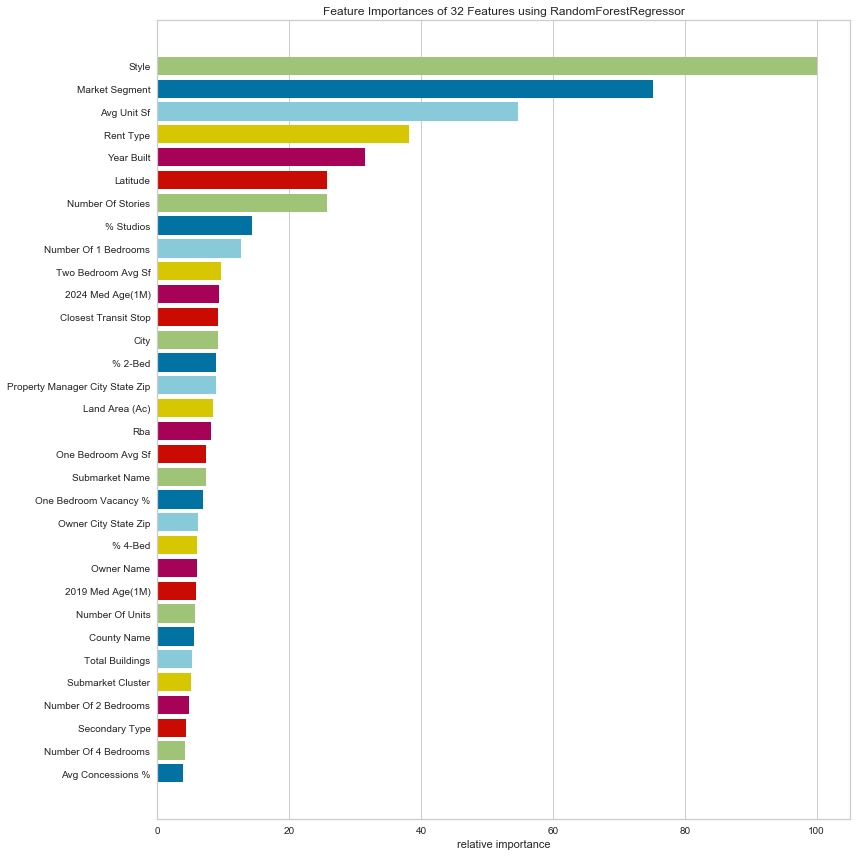

In [42]:
plt.figure(figsize=(12,12))
ax = plt.gca()
labels = list(map(lambda s: s.title(), sel))
model = RandomForestRegressor(n_estimators=100)
viz = FeatureImportances(model, labels=labels)
viz.fit(X, y)
viz.show(ax=ax)

### Plot feature importance for Linear Regression

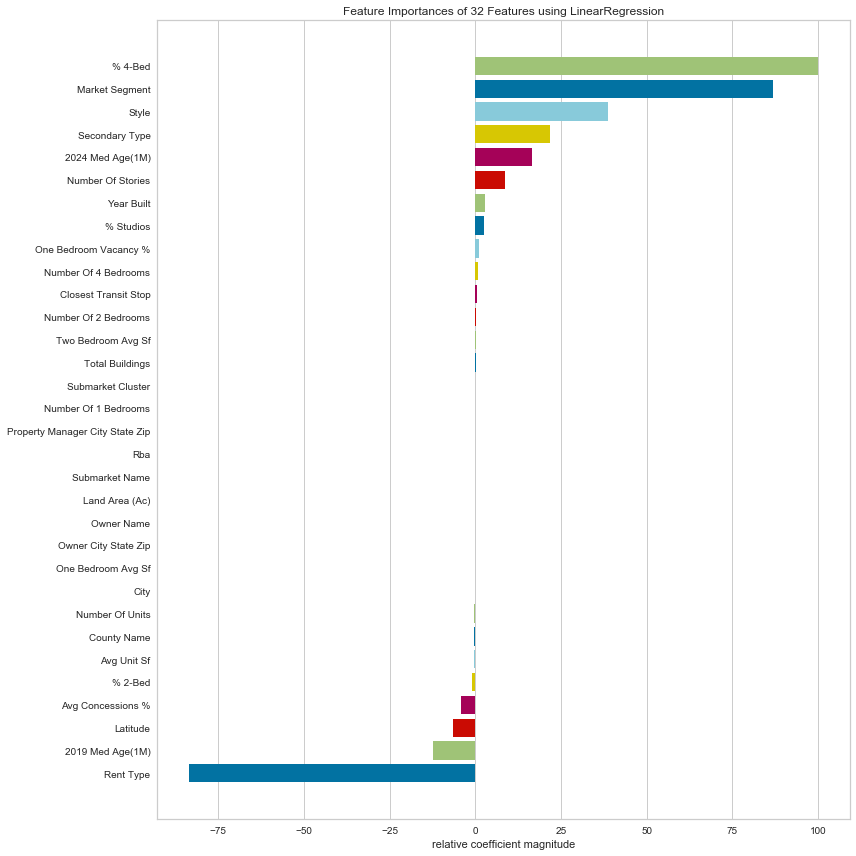

In [43]:
plt.figure(figsize=(12,12))
ax = plt.gca()
labels = list(map(lambda s: s.title(), sel))
viz = FeatureImportances(LinearRegression(n_jobs=-1), labels=labels)
viz.fit(X, y)
viz.show(ax=ax)

### Plot Pearson correlation 

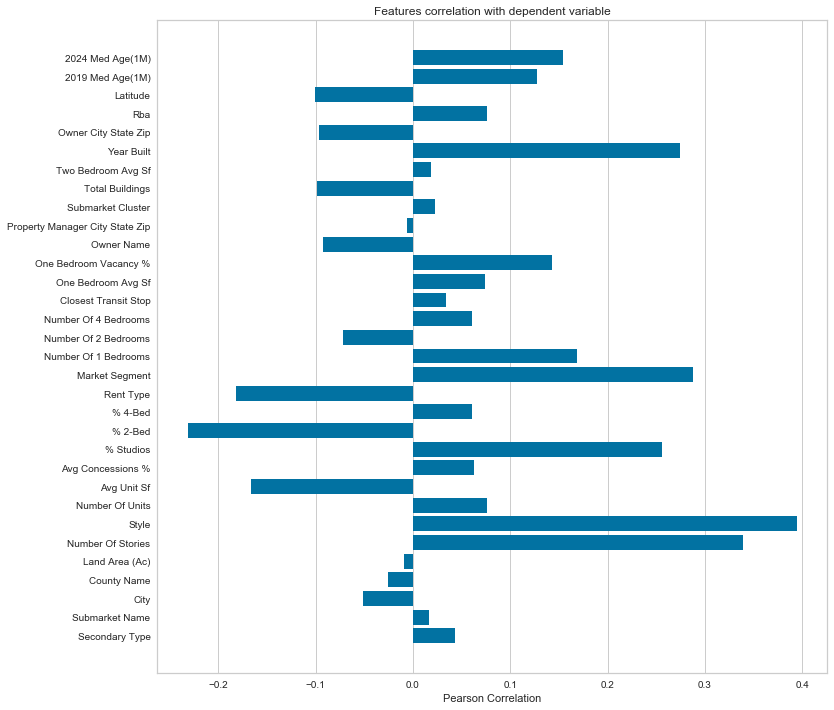

In [44]:
plt.figure(figsize=(12,12))
ax = plt.gca()
visualizer = FeatureCorrelation(labels=labels)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show(ax =ax)           # Finalize and render the figure

### Plot Shapiro Ranking of features

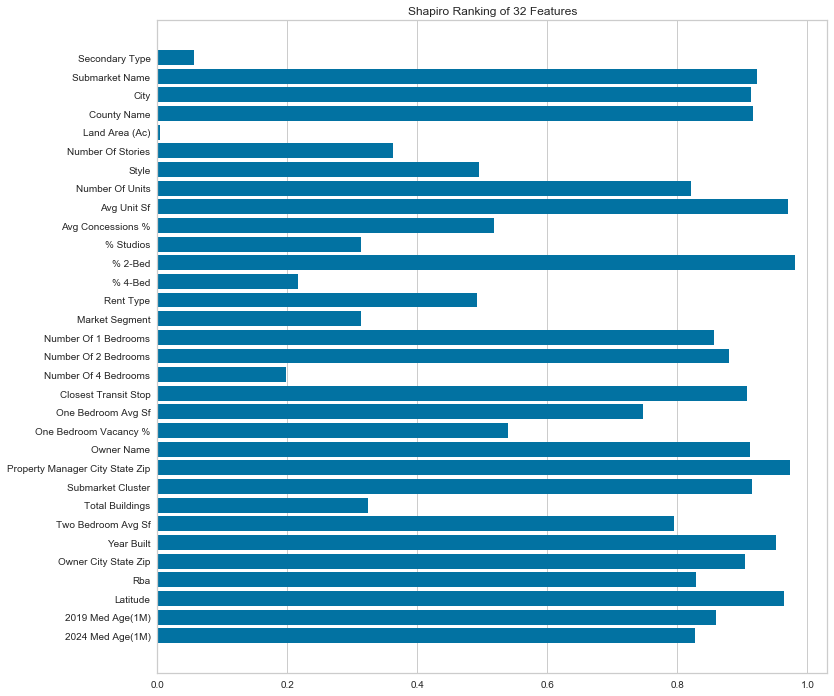

In [45]:
plt.figure(figsize=(12,12))
ax = plt.gca()
# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(algorithm='shapiro', features = labels)

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show(ax = ax)              # Finalize and render the figure

In [46]:
df.head()

,Star Rating,Building Status,Secondary Type,Market Name,Submarket Name,City,State,Zip,County Name,For Sale Status,Land Area (AC),Number Of Stories,Style,Number Of Units,Vacancy %,Avg Unit SF,Avg Effective/SF,Avg Concessions %,% Studios,% 1-Bed,% 2-Bed,% 3-Bed,% 4-Bed,Rent Type,Market Segment,Parking Spaces/Unit,Number Of Parking Spaces,Amenities,Number Of 1 Bedrooms,Number Of 2 Bedrooms,Number Of 3 Bedrooms,Number Of 4 Bedrooms,Building Class,Closest Transit Stop,Closest Transit Stop Dist (mi),Construction Material,Features,Four Bedroom Avg SF,Four Bedroom Concessions %,Four Bedroom Vacancy %,Four Bedroom Vacant Units,Number Of Studios,One Bedroom Avg SF,One Bedroom Concessions %,One Bedroom Vacancy %,One Bedroom Vacant Units,Owner Name,Property Manager Address,Property Manager City State Zip,Property Manager Name,Property Manager Phone,PropertyType,Studio Avg SF,Studio Concessions %,Studio Vacancy %,Studio Vacant Units,Submarket Cluster,Three Bedroom Avg SF,Three Bedroom Concessions %,Three Bedroom Vacancy %,Three Bedroom Vacant Units,Total Buildings,Two Bedroom Avg SF,Two Bedroom Concessions %,Two Bedroom Vacancy %,Two Bedroom Vacant Units,Year Built,Year Renovated,Owner Address,Owner City State Zip,RBA,Parcel Number 1(Min),Parcel Number 2(Max),Latitude,Longitude,2019 Med Age(1m),2024 Med Age(1m),Situs_Num,Situs_Num_Remainder,SITUS_NAM,Grill,Tennis Court,Property Manager on Site,Car Wash Area,Playground,Elevator,Picnic Area,Maintenance on site,Media Center/Movie Theatre,Business Center,Wi-Fi,Concierge,Pool,Courtyard,Lounge,Spa,Cabana,Laundry Facilities,Gameroom,Sundeck,Laundry Service,Walking/Biking Trails,Storage Space,Package Service,Fitness Center,Breakfast/Coffee Concierge,Gated,Volleyball Court,Planned Social Activities,Furnished Units Available,Recycling,Clubhouse,Pet Play Area,Basketball Court,24 Hour Access,Controlled Access
0,4,Existing,Apartments,Atlanta,Outlying Fulton County MF,Johns Creek,GA,30097,Fulton,N,8.9600,3.0,Garden,210,4.29,1157.0,1.46,1.4,0.00,35.71,46.67,17.62,0.0000,Market,All,1.095,230.0,"Business Center, Controlled Access, Clubhouse,...",75.0,98.0,37.0,0.0,A,Hartsfield-Jackson Atlanta International,39.485,Masonry,"Business Center, Controlled Access, Clubhouse,...",0.0,0.0,0.0,0.0,0.0,914.0,0.5,4.0,3.0,"Jones Lang LaSalle Income Property Trust, Inc.",6215 Johns Creek Cmn,"Johns Creek, GA 300971535",Carter Haston- Reserve at Johns Creek Walk,6.784754e+09,Multi-Family,0.0,0.0,0.0,0.0,North Fulton MF,1602.0,0.7,5.4,2.0,7.0,1175.0,2.2,4.1,4.0,2006.0,-1.0,333 W Wacker Dr Suite # 2300,"Chicago, IL 606061220",260872.0,11-1000-0359-034,11-1000-0359-034-1,34.050153,-84.178580,35.5,35.9,6215.0,Johns Creek Cmn,Johns Creek Cmn,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1
3,4,Existing,Apartments,Atlanta,Piedmont Park MF,Atlanta,GA,30309,Fulton,N,1.5700,4.0,Mid-Rise,188,4.79,942.0,2.11,0.6,32.45,45.21,22.34,0.00,0.0000,Market,All,1.223,230.0,"Business Center, Controlled Access, Courtyard,...",85.0,42.0,0.0,0.0,B,Midtown,0.450,Masonry,"Business Center, Controlled Access, Courtyard,...",0.0,0.0,0.0,0.0,61.0,870.0,0.6,4.7,4.0,"Mid-America Apartment Communities, Inc.",250 10th St,"Atlanta, GA 30309",MAA - Post Parkside,4.048178e+09,Multi-Family,765.0,0.6,4.9,3.0,Midtown Atlanta MF,0.0,0.0,0.0,0.0,3.0,1291.0,0.6,4.8,2.0,1999.0,-1.0,6815 Poplar Ave Suite # 500,"Germantown, TN 381383606",243660.0,17-0106-0009-120-4,17-0106-0009-120-4,33.782037,-84.378623,36.1,39.2,250.0,10th St NE,10th St,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
4,3,Existing,Apartments,Atlanta,Central Midtown MF,Atlanta,GA,30309,Fulton,N,NaN,9.0,Mid-Rise,118,11.02,1068.0,2.11,1.0,0.00,0.00,61.02,0.00,0.3898,Market,Student,0.847,100.0,"24 Hour Access, Business Center, Laundry Facil...",0.0,72.0,0.0,46.0,B,Midtown,0.300,Reinforced Concrete,"24 Hour Access, Business Center, Laundry Facil...",1330.0,1.0,10.9,5.0,0.0,0.0,0.0,0.0,0.0,"The Pierce Company, Inc.",100 10th St NW,"Atlanta, GA 30309",Pierce 

# Wordclouds for amenities in the top 25% of properties by average rent/SF

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maheshpandit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


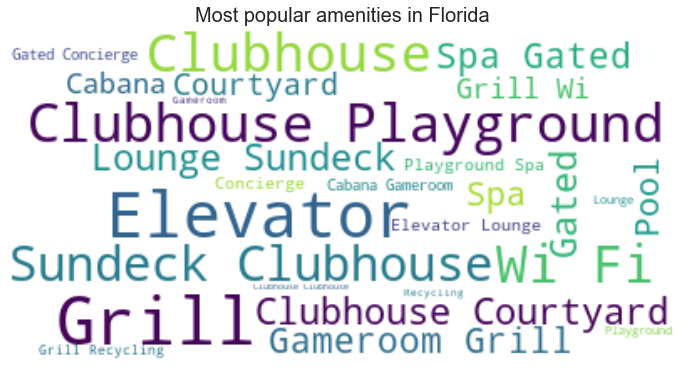

In [62]:
nltk.download('punkt')

d = df[(df['Avg Effective/SF']>df['Avg Effective/SF'].quantile([0.75])[0.75])&(df["State"]=="FL")]

wanted = list(feature_freq[feature_freq['Percentage']>0.05]['Feature'])

fig, ax = plt.subplots(figsize=(12,8))

text = functools.reduce(lambda a,b: a + " " + str(b), d.sample(frac=0.3)['Features'])
text = ' '.join([w for w in nltk.word_tokenize(text) if w in wanted])

wc = wordcloud.WordCloud(background_color = 'white', max_font_size=40).generate(text)
ax.imshow(wc, interpolation='bilinear')
ax.set_title("Most popular amenities in Florida", fontsize = 20 )
plt.axis("off")
fig.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maheshpandit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


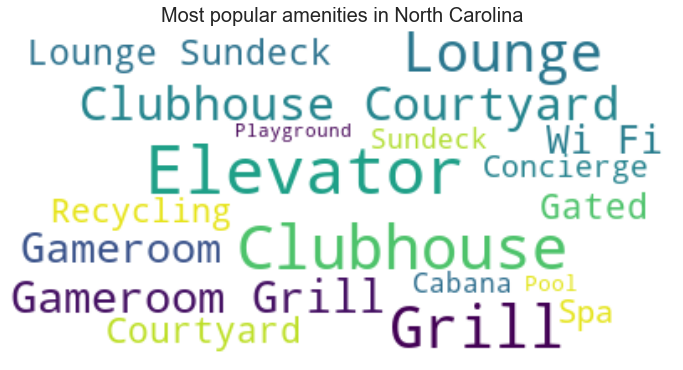

In [63]:
nltk.download('punkt')

d = df[(df['Avg Effective/SF']>df['Avg Effective/SF'].quantile([0.75])[0.75])&(df["State"]=="NC")]

wanted = list(feature_freq[feature_freq['Percentage']>0.05]['Feature'])

fig, ax = plt.subplots(figsize=(12,8))

text = functools.reduce(lambda a,b: a + " " + str(b), d.sample(frac=0.3)['Features'])
text = ' '.join([w for w in nltk.word_tokenize(text) if w in wanted])

wc = wordcloud.WordCloud(background_color = 'white', max_font_size=40).generate(text)
ax.imshow(wc, interpolation='bilinear')
ax.set_title("Most popular amenities in North Carolina", fontsize = 20 )
plt.axis("off")
fig.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maheshpandit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


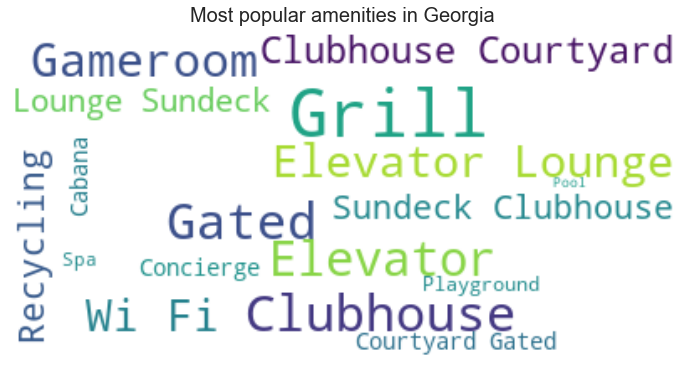

In [65]:
nltk.download('punkt')

d = df[(df['Avg Effective/SF']>df['Avg Effective/SF'].quantile([0.75])[0.75])&(df["State"]=="GA")]

wanted = list(feature_freq[feature_freq['Percentage']>0.05]['Feature'])

fig, ax = plt.subplots(figsize=(12,8))

text = functools.reduce(lambda a,b: a + " " + str(b), d.sample(frac=0.3)['Features'])
text = ' '.join([w for w in nltk.word_tokenize(text) if w in wanted])

wc = wordcloud.WordCloud(background_color = 'white', max_font_size=40).generate(text)
ax.imshow(wc, interpolation='bilinear')
ax.set_title("Most popular amenities in Georgia", fontsize = 20 )
plt.axis("off")
fig.show()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maheshpandit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


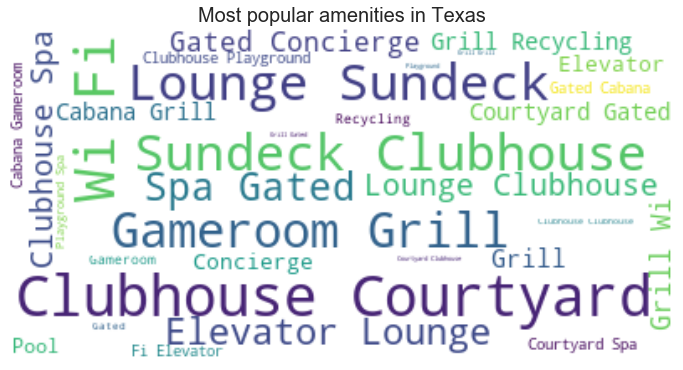

In [66]:
nltk.download('punkt')

d = df[(df['Avg Effective/SF']>df['Avg Effective/SF'].quantile([0.75])[0.75])&(df["State"]=="TX")]

wanted = list(feature_freq[feature_freq['Percentage']>0.05]['Feature'])

fig, ax = plt.subplots(figsize=(12,8))

text = functools.reduce(lambda a,b: a + " " + str(b), d.sample(frac=0.3)['Features'])
text = ' '.join([w for w in nltk.word_tokenize(text) if w in wanted])

wc = wordcloud.WordCloud(background_color = 'white', max_font_size=40).generate(text)
ax.imshow(wc, interpolation='bilinear')
ax.set_title("Most popular amenities in Texas", fontsize = 20 )
plt.axis("off")
fig.show()

# Boxplots for the distribution of rent for different types of rooms in each state

<Figure size 2400x1600 with 0 Axes>

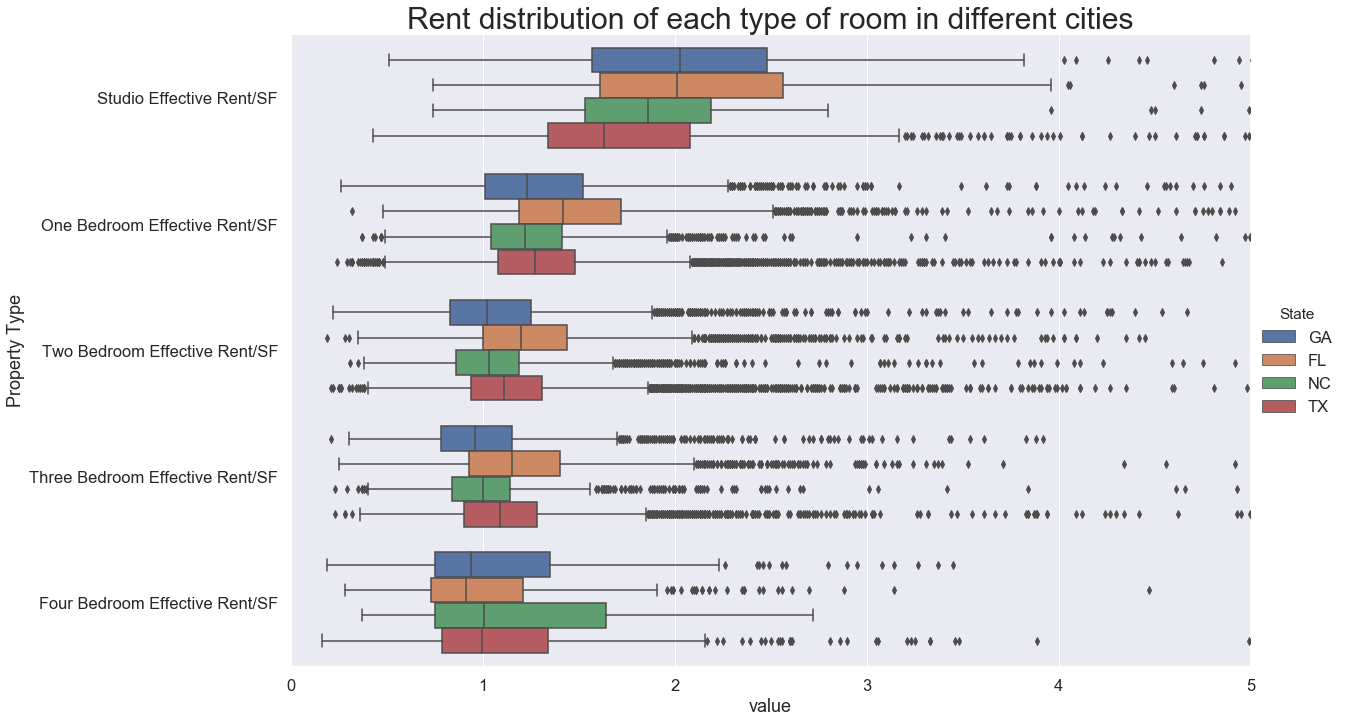

In [77]:
data = pd.read_excel("~/Documents/DSO545/Project/Datasets/Property Data Compiled.xlsx")


GAs = data.loc[data["State"] == 'GA',["State","Studio Effective Rent/SF"]].dropna()
FLs = data.loc[data["State"] == 'FL',["State","Studio Effective Rent/SF"]].dropna()
NCs = data.loc[data["State"] == 'NC',["State","Studio Effective Rent/SF"]].dropna()
TXs = data.loc[data["State"] == 'TX',["State","Studio Effective Rent/SF"]].dropna()

cdfs = pd.concat([GAs, FLs, NCs, TXs])

mdfs = pd.melt(cdfs, id_vars=['State'], var_name=['Property Type'])

GA1 = data.loc[data["State"] == 'GA',["State","One Bedroom Effective Rent/SF"]].dropna()
FL1 = data.loc[data["State"] == 'FL',["State","One Bedroom Effective Rent/SF"]].dropna()
NC1 = data.loc[data["State"] == 'NC',["State","One Bedroom Effective Rent/SF"]].dropna()
TX1 = data.loc[data["State"] == 'TX',["State","One Bedroom Effective Rent/SF"]].dropna()

cdf1 = pd.concat([GA1, FL1, NC1, TX1])

mdf1 = pd.melt(cdf1, id_vars=['State'], var_name=['Property Type']) 

GA2 = data.loc[data["State"] == 'GA',["State","Two Bedroom Effective Rent/SF"]].dropna()
FL2 = data.loc[data["State"] == 'FL',["State","Two Bedroom Effective Rent/SF"]].dropna()
NC2 = data.loc[data["State"] == 'NC',["State","Two Bedroom Effective Rent/SF"]].dropna()
TX2 = data.loc[data["State"] == 'TX',["State","Two Bedroom Effective Rent/SF"]].dropna()

cdf2 = pd.concat([GA2, FL2, NC2, TX2])

mdf2 = pd.melt(cdf2, id_vars=['State'], var_name=['Property Type']) 

GA3 = data.loc[data["State"] == 'GA',["State","Three Bedroom Effective Rent/SF"]].dropna()
FL3 = data.loc[data["State"] == 'FL',["State","Three Bedroom Effective Rent/SF"]].dropna()
NC3 = data.loc[data["State"] == 'NC',["State","Three Bedroom Effective Rent/SF"]].dropna()
TX3 = data.loc[data["State"] == 'TX',["State","Three Bedroom Effective Rent/SF"]].dropna()

cdf3 = pd.concat([GA3, FL3, NC3, TX3])

mdf3 = pd.melt(cdf3, id_vars=['State'], var_name=['Property Type']) 

GA4 = data.loc[data["State"] == 'GA',["State","Four Bedroom Effective Rent/SF"]].dropna()
FL4 = data.loc[data["State"] == 'FL',["State","Four Bedroom Effective Rent/SF"]].dropna()
NC4 = data.loc[data["State"] == 'NC',["State","Four Bedroom Effective Rent/SF"]].dropna()
TX4 = data.loc[data["State"] == 'TX',["State","Four Bedroom Effective Rent/SF"]].dropna()

cdf4 = pd.concat([GA4, FL4, NC4, TX4])

mdf4 = pd.melt(cdf4, id_vars=['State'], var_name=['Property Type']) 

d = pd.concat([mdfs,mdf1,mdf2,mdf3,mdf4])

plt.figure(figsize = (12,8),dpi = 200)
sns.set(font_scale=1.5)
f = sns.catplot(x="value", y="Property Type", hue="State", data=d, kind='box', height=10, aspect = 1.8)
f.axes[0][0].set_xlim(0,5)
plt.title('Rent distribution of each type of room in different cities', fontsize = 30)
plt.show()

# Map showing the locations of different properties and the corresponding average rent/SF

In [81]:
scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

In [83]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = df['Avg Effective/SF'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.6,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = df['Avg Effective/SF'],
            cmax = df['Avg Effective/SF'].max(),
            colorbar_title="Avg Effective Rent/SF",
        )))

fig.update_layout(
        title = 'Rent',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5,
        ),
    )
fig.show()